$$\textbf{PLN. Examen 1: Minería de texto para Turismo}$$
$$\textit{Y. Sarahi García Gozález}$$

<font size=4.5 color='lightblue'>

$\textit{Librerías}$

In [1]:
import pandas as pd
import numpy as np
import nltk
import string
from math import log10,log2
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
import re
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer


<font size=4.5 color='lightblue'>

$\textit{Preprocesamiento de los datos}$

In [2]:
#obtenemos los nombres de cada hoja del excel
path="/Users/ely/Documents/Maestria/segundo_semestre/cimat2023-1/lenguaje/Proyecto_1_lenguaje/"
excel = openpyxl.load_workbook(path+"Opiniones.xlsx")
nombres = excel.sheetnames
excel.close()
# Eliminamos los números de los nombres de las hojas
solo_nombres= [re.sub(r'[\d,]+', '', nombre).strip() for nombre in nombres]
solo_nombres

['Basilica Colegiata',
 'Mercado Hidalgo',
 'Casa de Diego Rivera',
 'Universidad de Guanajuato',
 'Alhóndiga',
 'Teatro Juárez',
 'Jardín de la Unión',
 'Callejón del Beso',
 'Monumento Pípila',
 'Museo de las Momias']

In [3]:
dataframes_por_hoja = {}# diccionario para almacenar los DataFrames
for nombre_hoja in nombres: #Iteramos sobre cada hoja del excel
    #creamos un dataframe para cada hoja
    df = pd.read_excel(path+"Opiniones.xlsx",sheet_name= nombre_hoja) 
    # Agregamos el DF al diccionario
    dataframes_por_hoja[nombre_hoja] = df

In [4]:
for nombre_hoja in nombres: #Iteramos sobre cada hoja del excel
    #eliminamos las columnas que no utilizaremos 
    dataframes_por_hoja[nombre_hoja] = dataframes_por_hoja[nombre_hoja].drop(columns=["Dispositivo","Número de aportaciones"])
    # Reemplazamos los valores 'Femenino' y 'Masculino' por 0 y 1, respectivamente
    dataframes_por_hoja[nombre_hoja]['Género'] = dataframes_por_hoja[nombre_hoja]['Género'].replace({'Femenino': 0, 'Masculino': 1,' Masculino':1,'masculino':1})
    dataframes_por_hoja[nombre_hoja]['Nacional ó Internacional'] = dataframes_por_hoja[nombre_hoja]['Nacional ó Internacional'].replace({'Nacional': 0, 'Internacional': 1})

In [5]:
#Ejemplo de DF final
print("Hoja de ", nombres[2])
dataframes_por_hoja[nombres[2]].head()

Hoja de  Casa de Diego Rivera 698


Género  Edad  Nacional ó Internacional Calificación  Escala  \
0       0  25.0                         1    Muy bueno       4   
1       0  27.0                         1    Muy bueno       4   
2       0  25.0                         0    Muy bueno       4   
3       1  34.0                         1    Excelente       5   
4       1  60.0                         1    Muy bueno       4   

                                Título de la opinión  \
0                "Diego was Talented at Portraiture"   
1                                    "Hermoso museo"   
2                      "Visita diver-cultural... :)"   
3  "A great place to pay homage to the great pain...   
4  "Deeper insight into the artist plus other hig...   

                                             Opinión            País   Idioma  \
0  "Interesting small museum. The downstairs is t...  Estados Unidos   Inglés   
1  "Ubicado en la zona turística la casa donde el...       Argentina  Español   
2  "La exposición de obras de Diego Rivera es muy...          México  Español   
3  "Diego Rivera was born in Guanajuato and his f...        Colombia   Inglés   
4  "If you are interested in the man and his hist...  Estados Unidos   Inglés   

       Fecha  
0 2016-05-22  
1 2016-05-21  
2 2016-05-20  
3 2016-05-19  
4 2016-05-18

<font size=4.5 color='lightblue'>

$\textit{Preprocesamiento del texto}$

In [6]:
#lista de signos de puntuación
puntuacion = set(string.punctuation)

#definimos una función para quitar signos de puntuación y hacerlas minúsculas
def limpiar_opinion(opinion):
    opinion_sin_puntuacion = ''.join(caracter for caracter in opinion if caracter not in puntuacion)
    return opinion_sin_puntuacion.lower()

In [7]:
def create_corpus_from_text(text):
    corpus_palabras=[]
    exp_reg = r'\b[A-Za-z]+\b'  # \b indica límites de palabra, [A-Za-z]+ coincide con una o más letras 
    tokenizer = RegexpTokenizer(exp_reg)
    for documento in text:
        corpus_palabras+=tokenizer.tokenize(documento)

    return corpus_palabras


def create_dic_freq(corpus,n):
    fdist = nltk.FreqDist(corpus)
    aux=[(fdist[key],key) for key in fdist]
    aux.sort()
    aux.reverse()
    aux=aux[:n]

    return aux

def create_dic_ranking(dic_freq):
    dict_indices=dict()
    cont = 0
    for weight, word in dic_freq:
        dict_indices[word]= cont
        cont+= 1

    return dict_indices

In [8]:
listas_opiniones = []  #listas de opiniones de cada hoja
listas_escala=[] #lista de las escalas de cada escala
listas_opiniones_limpia = [] #listas de opiniones de cada hoja sin signos de puntuacion y en minusculas

for nombre_hoja in nombres:
    #Seleccionamos todas las opiniones de la hoja actual y creamos una lista de strings
    opiniones_hoja = [opinion.strip('"') for opinion in dataframes_por_hoja[nombre_hoja]['Opinión']]
    #Seleccionamos todas las opiniones de la hoja actual, pasamos el string a la función que limpia el texto y creamos una lista de strings
    lista_limpia = [limpiar_opinion(opinion.strip('"')) for opinion in dataframes_por_hoja[nombre_hoja]['Opinión']]
    #Seleccionamos todas las escalas de la hoja actual y creamos una lista de strings
    escala_hoja=[escala for escala in dataframes_por_hoja[nombre_hoja]['Escala']]

    #agregamos cada lista de de strings a una unica lista
    listas_opiniones.append(opiniones_hoja)
    listas_escala.append(escala_hoja)
    listas_opiniones_limpia.append(lista_limpia)

Ejemplo de la lista de comentarios para la basílica sin signos de puntuación y sin mayúculas:

In [9]:
listas_opiniones_limpia[0][:20]

['basílica muy bien conservada punto central en la ciudad  muy linda por dentro vale la pena darse una vuelta para conocer  alto significado religioso y arquitectónico',
 'the basilica guanajuato does not have a cathedral it is situated in the nearby city of leon is truly imposing both during the day and when illuminated at night it also has some lovely polychrome sculpture and a great organ',
 'edificio de la iglesia amarilla es un abigarrado y nahu crear una más bella de atocha he venido a cabo mejor en frente de la misma guanajuato es menor cuando se toman fotografías que gabolman menos una',
 'a must see place in town and very nice to go inside and beautiful outside to take pics in the center of town',
 'not particularly impressive but if you like historic buildings of any type this is worth a walkin',
 'wandered into the church on a sunday evening during mass the lovely chandeliers were alit and looked beautiful the outside is also lighted at night and though not huge it certainly

Ejemplo de las calificaciones correspodientes a los 20 comentarios anteriores:

In [10]:
listas_escala[0][:20]

[4, 5, 5, 5, 3, 4, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4]

In [11]:
# Obtener la lista de palabras vacías
stop_words= set(stopwords.words('english')+stopwords.words('spanish'))  

In [12]:
lista_corpus=[]
lista_dict_freq=[]
lista_dict_indices=[]

for i,nombre_hoja in enumerate(nombres):
    #Generamos el corpus
    corpus_palabras=create_corpus_from_text(listas_opiniones_limpia[i])
    #quitamos stopwords
    corpus_filtrado = [word for word in corpus_palabras if word not in stop_words]
    #Generamos diccionario de frecuencias con las primeras 5 mil palabras sin stop words
    dict_freq=create_dic_freq(corpus_filtrado,5000)
    #Generamos diccionario de indices
    dict_indices=create_dic_ranking(dict_freq)
    
    #guardamos en una lista de listas cada corpus, diccionario de frecuencias y de rankings
    lista_corpus.append(corpus_filtrado)
    lista_dict_freq.append(dict_freq)
    lista_dict_indices.append(dict_indices)  

Ejemplo de corpus generado a partir de todos los comentarios de la basílica en minúsculas y sin stopwords

In [13]:
lista_corpus[0][:20]

['bien',
 'conservada',
 'punto',
 'central',
 'ciudad',
 'linda',
 'dentro',
 'vale',
 'pena',
 'darse',
 'vuelta',
 'conocer',
 'alto',
 'significado',
 'religioso',
 'basilica',
 'guanajuato',
 'cathedral',
 'situated',
 'nearby']

Ejemplo de los diccionarios de frecuencias y de ranking para la basícila creados a partir del corpus anterior

In [14]:
lista_dict_freq[0][:20]

[(249, 'guanajuato'),
 (147, 'ciudad'),
 (122, 'iglesia'),
 (98, 'lugar'),
 (89, 'basilica'),
 (88, 'hermosa'),
 (88, 'beautiful'),
 (87, 'church'),
 (83, 'centro'),
 (72, 'noche'),
 (70, 'interior'),
 (64, 'plaza'),
 (64, 'arquitectura'),
 (58, 'inside'),
 (56, 'dentro'),
 (51, 'city'),
 (48, 'one'),
 (47, 'bonita'),
 (46, 'si'),
 (41, 'visitar')]

In [15]:
lista_dict_indices[0]

{'guanajuato': 0,
 'ciudad': 1,
 'iglesia': 2,
 'lugar': 3,
 'basilica': 4,
 'hermosa': 5,
 'beautiful': 6,
 'church': 7,
 'centro': 8,
 'noche': 9,
 'interior': 10,
 'plaza': 11,
 'arquitectura': 12,
 'inside': 13,
 'dentro': 14,
 'city': 15,
 'one': 16,
 'bonita': 17,
 'si': 18,
 'visitar': 19,
 'see': 20,
 'paz': 21,
 'pena': 22,
 'historia': 23,
 'visit': 24,
 'vale': 25,
 'hermoso': 26,
 'encuentra': 27,
 'bien': 28,
 'color': 29,
 'visita': 30,
 'town': 31,
 'exterior': 32,
 'virgen': 33,
 'templo': 34,
 'ver': 35,
 'iglesias': 36,
 'puede': 37,
 'great': 38,
 'around': 39,
 'night': 40,
 'amarillo': 41,
 'tomar': 42,
 'place': 43,
 'churches': 44,
 'catedral': 45,
 'many': 46,
 'gran': 47,
 'worth': 48,
 'time': 49,
 'puedes': 50,
 'day': 51,
 'bella': 52,
 'outside': 53,
 'lugares': 54,
 'visitarla': 55,
 'parte': 56,
 'hace': 57,
 'estilo': 58,
 'teatro': 59,
 'mass': 60,
 'cerca': 61,
 'center': 62,
 'altar': 63,
 'must': 64,
 'mas': 65,
 'fotos': 66,
 'colores': 67,
 'amazin

<font size=4.5 color='lightblue'>

$\textit{Actividades}$

<font size=2.5 color='lightblue'>

* $\textit{Ejercicio 1}$


In [16]:
promedios=[]
for nombre_hoja,solo_nombre in zip(nombres,solo_nombres): #Iteramos sobre cada hoja del excel
    prom=dataframes_por_hoja[nombre_hoja]["Escala"].mean()
    promedios.append((solo_nombre,prom))
    print("\n")
    print("*", solo_nombre)
    print("Total de calificaciones: ",dataframes_por_hoja[nombre_hoja]["Escala"].shape)
    print("Promedio: ",prom)
    print("Desviacion estándar: ",dataframes_por_hoja[nombre_hoja]["Escala"].std())
promedios = sorted(promedios, key=lambda x: x[1])



* Basilica Colegiata
Total de calificaciones:  (560,)
Promedio:  4.5
Desviacion estándar:  0.6687504702153396


* Mercado Hidalgo
Total de calificaciones:  (600,)
Promedio:  3.9483333333333333
Desviacion estándar:  0.9507033977392814


* Casa de Diego Rivera
Total de calificaciones:  (698,)
Promedio:  4.243553008595988
Desviacion estándar:  0.8040392901549579


* Universidad de Guanajuato
Total de calificaciones:  (900,)
Promedio:  4.6033333333333335
Desviacion estándar:  0.6126130687218946


* Alhóndiga
Total de calificaciones:  (930,)
Promedio:  4.45483870967742
Desviacion estándar:  0.7457112582889636


* Teatro Juárez
Total de calificaciones:  (1010,)
Promedio:  4.702970297029703
Desviacion estándar:  0.5181455546147319


* Jardín de la Unión
Total de calificaciones:  (1134,)
Promedio:  4.591710758377425
Desviacion estándar:  0.6073702093154869


* Callejón del Beso
Total de calificaciones:  (1360,)
Promedio:  3.9955882352941177
Desviacion estándar:  0.9712472464286253


* Monume

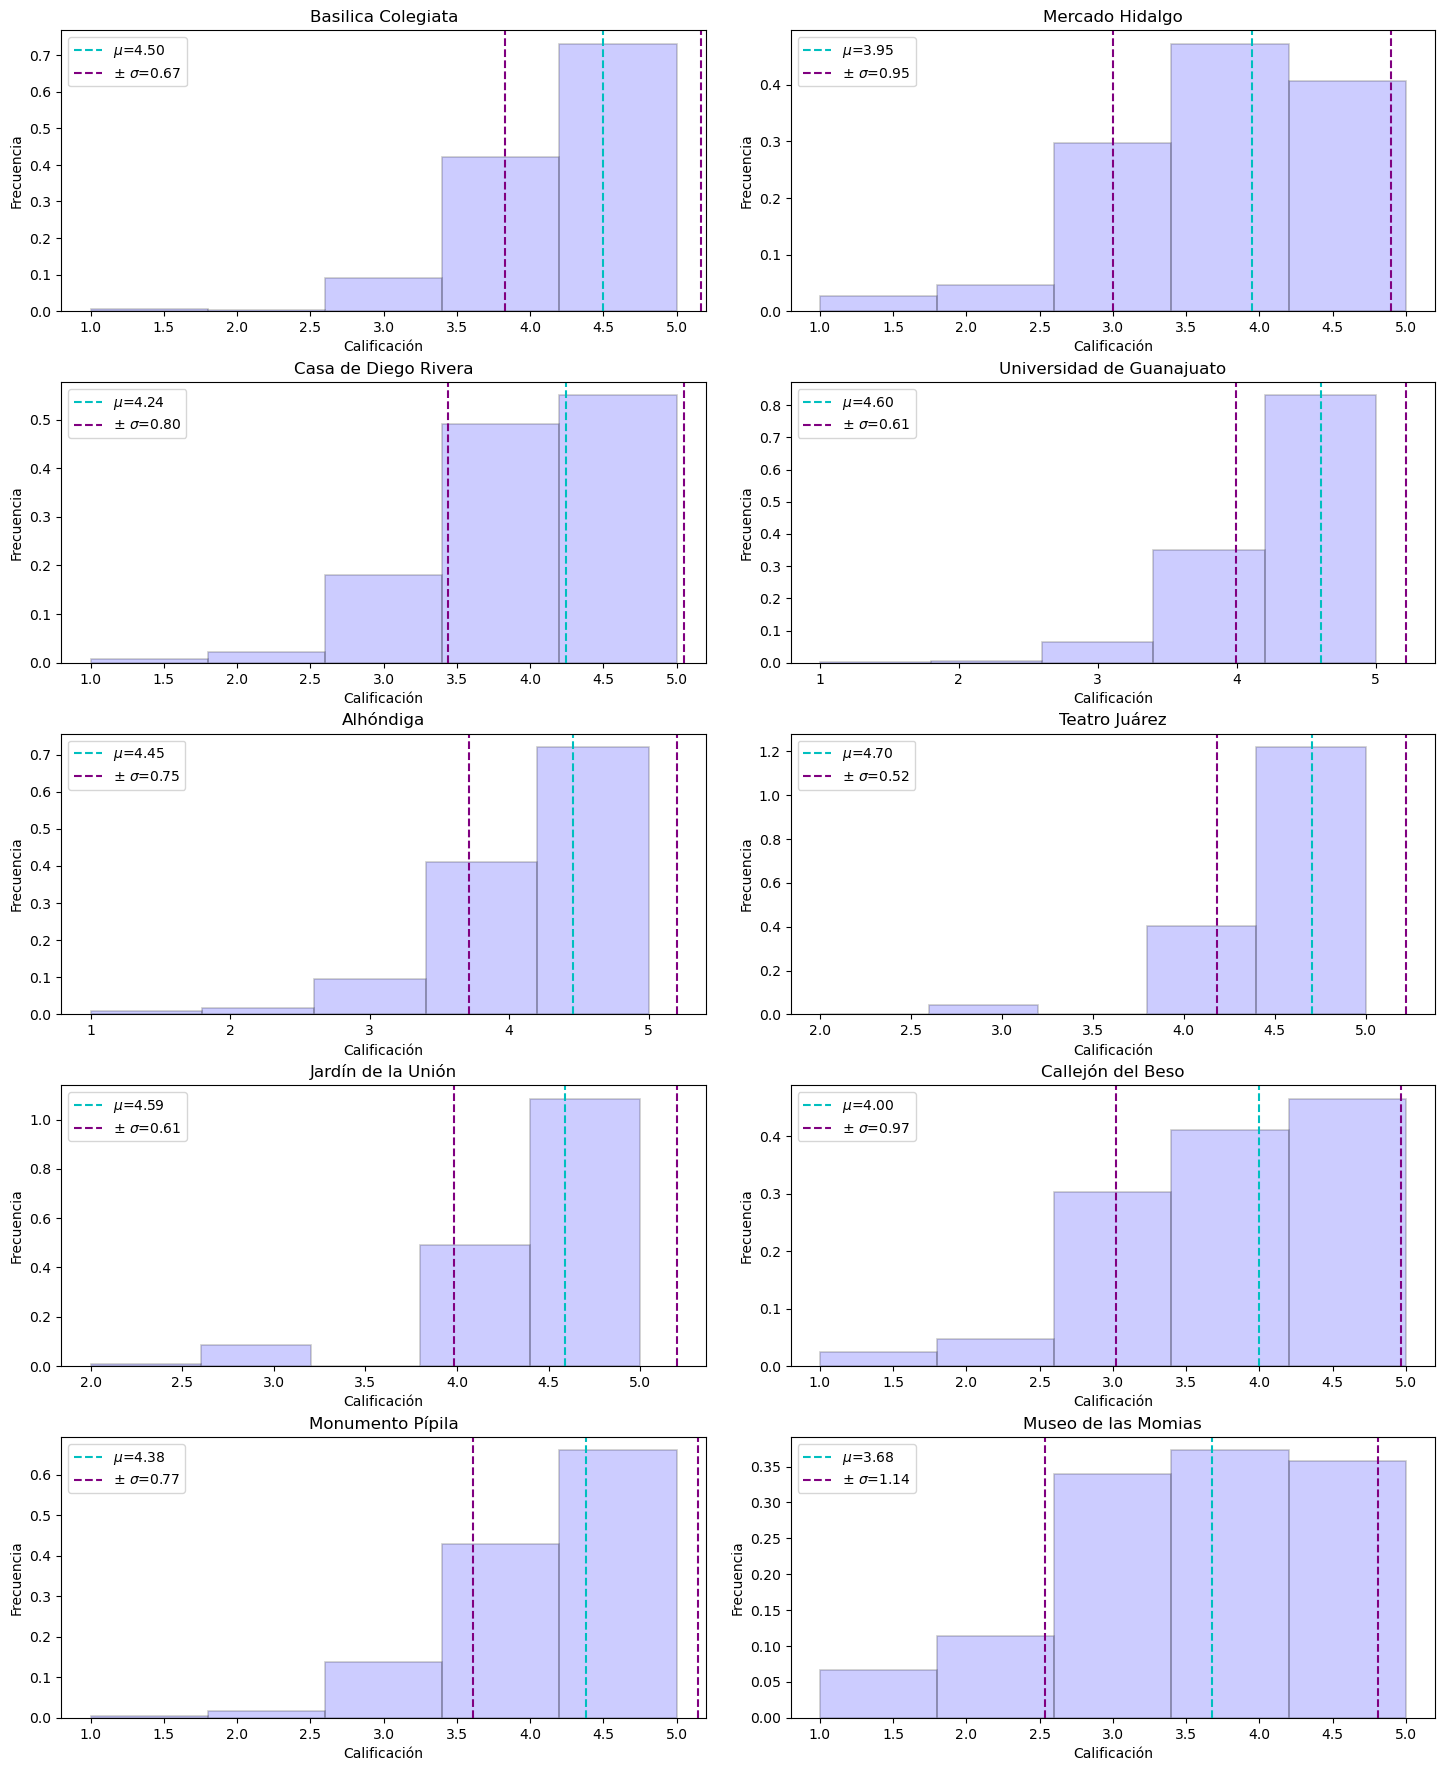

In [17]:
num_subplots = len(nombres)

#Crea una nueva figura para los subgráficos
fig, axs = plt.subplots(5, 2, figsize=(15, 18))

#Ajusta el diseño de los subgráficos
fig.tight_layout(pad=3.0)
i=0
# Itera sobre los nombres de las hojas y crea un subgráfico para cada uno
for nombre_hoja,solo_nombre in zip(nombres,solo_nombres):

    #Selecciona el subgráfico actual
    ax = axs[i//2, i%2] if num_subplots > 1 else axs
    
    #Calcula el promedio y la desviación estándar de la columna 'Escala' para la hoja actual
    promedio = dataframes_por_hoja[nombre_hoja]['Escala'].mean()
    desviacion_estandar = dataframes_por_hoja[nombre_hoja]['Escala'].std()

    #promedio
    ax.axvline(x=promedio, color='c', linestyle='--', label=f'$\mu$={promedio:.2f}')
    #hist
    ax.hist(dataframes_por_hoja[nombre_hoja]['Escala'], bins=5, alpha=0.2, color='b', edgecolor='black', linewidth=1.2, density=True)

    #desviación estándar 
    ax.axvline(x=promedio + desviacion_estandar, color='purple', linestyle='--', label=f'$\pm$ $\sigma$={desviacion_estandar:.2f}')
    ax.axvline(x=promedio - desviacion_estandar, color='purple', linestyle='--')
  
    #título uy ejes
    ax.set_title(f'{solo_nombre}')
    ax.set_xlabel('Calificación')
    ax.set_ylabel('Frecuencia')
    ax.legend()
    i=i+1

# Muestra los subgráficos
plt.show()

Ordenando los lugares de acuerdo a su calificación promedio (de menor a mayor), tenemos que:

In [18]:
promedios

[('Museo de las Momias', 3.6751515151515153),
 ('Mercado Hidalgo', 3.9483333333333333),
 ('Callejón del Beso', 3.9955882352941177),
 ('Casa de Diego Rivera', 4.243553008595988),
 ('Monumento Pípila', 4.377777777777778),
 ('Alhóndiga', 4.45483870967742),
 ('Basilica Colegiata', 4.5),
 ('Jardín de la Unión', 4.591710758377425),
 ('Universidad de Guanajuato', 4.6033333333333335),
 ('Teatro Juárez', 4.702970297029703)]

In [19]:
numero_palabras = []  # Lista para almacenar las longitudes de los comentarios
for lista_opiniones_hoja in listas_opiniones_limpia:
    # Obtener las longitudes de cada comentario en la hoja actual y agregarlas a la lista
    longitudes_hoja = [len(opinion.split()) for opinion in lista_opiniones_hoja]
    numero_palabras.append(longitudes_hoja)

#agregamos la longitud al dataframe
for i,nombre_hoja in enumerate(nombres): #Iteramos sobre cada hoja del excel 
    dataframes_por_hoja[nombre_hoja]['longitud']= numero_palabras[i]

In [20]:
promedios_longitud=[]
print("Tomando en cuenta sólo EL NÚMERO DE PALABRAS en las opiniones (no singos, no espacios etc):")
for nombre_hoja,solo_nombre in zip(nombres,solo_nombres): #Iteramos sobre cada hoja del excel
    prom=dataframes_por_hoja[nombre_hoja]["longitud"].mean()
    promedios_longitud.append((solo_nombre,prom))
    print("\n")
    print("*", solo_nombre)
    print("Promedio: ",prom)
    print("Desviacion estándar: ",dataframes_por_hoja[nombre_hoja]["longitud"].std())
    print("max: ",dataframes_por_hoja[nombre_hoja]["longitud"].max(),", mín: ",dataframes_por_hoja[nombre_hoja]["longitud"].min())


Tomando en cuenta sólo EL NÚMERO DE PALABRAS en las opiniones (no singos, no espacios etc):


* Basilica Colegiata
Promedio:  39.614285714285714
Desviacion estándar:  29.35601853412387
max:  253 , mín:  7


* Mercado Hidalgo
Promedio:  45.52333333333333
Desviacion estándar:  33.45342046972321
max:  394 , mín:  9


* Casa de Diego Rivera
Promedio:  49.15042979942693
Desviacion estándar:  30.39432866544417
max:  259 , mín:  12


* Universidad de Guanajuato
Promedio:  35.33777777777778
Desviacion estándar:  20.012657717456733
max:  205 , mín:  8


* Alhóndiga
Promedio:  46.44731182795699
Desviacion estándar:  33.88351346440856
max:  388 , mín:  8


* Teatro Juárez
Promedio:  41.4039603960396
Desviacion estándar:  27.06119746947791
max:  288 , mín:  7


* Jardín de la Unión
Promedio:  43.023809523809526
Desviacion estándar:  36.87054662495047
max:  549 , mín:  9


* Callejón del Beso
Promedio:  45.453676470588235
Desviacion estándar:  32.85906625553907
max:  669 , mín:  7


* Monumento Píp

/Users/ely/Documents/Maestria/segundo_semestre/cimat2023-1/lenguaje/.conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ely/Documents/Maestria/segundo_semestre/cimat2023-1/lenguaje/.conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ely/Documents/Maestria/segundo_semestre/cimat2023-1/lenguaje/.conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ely/Document

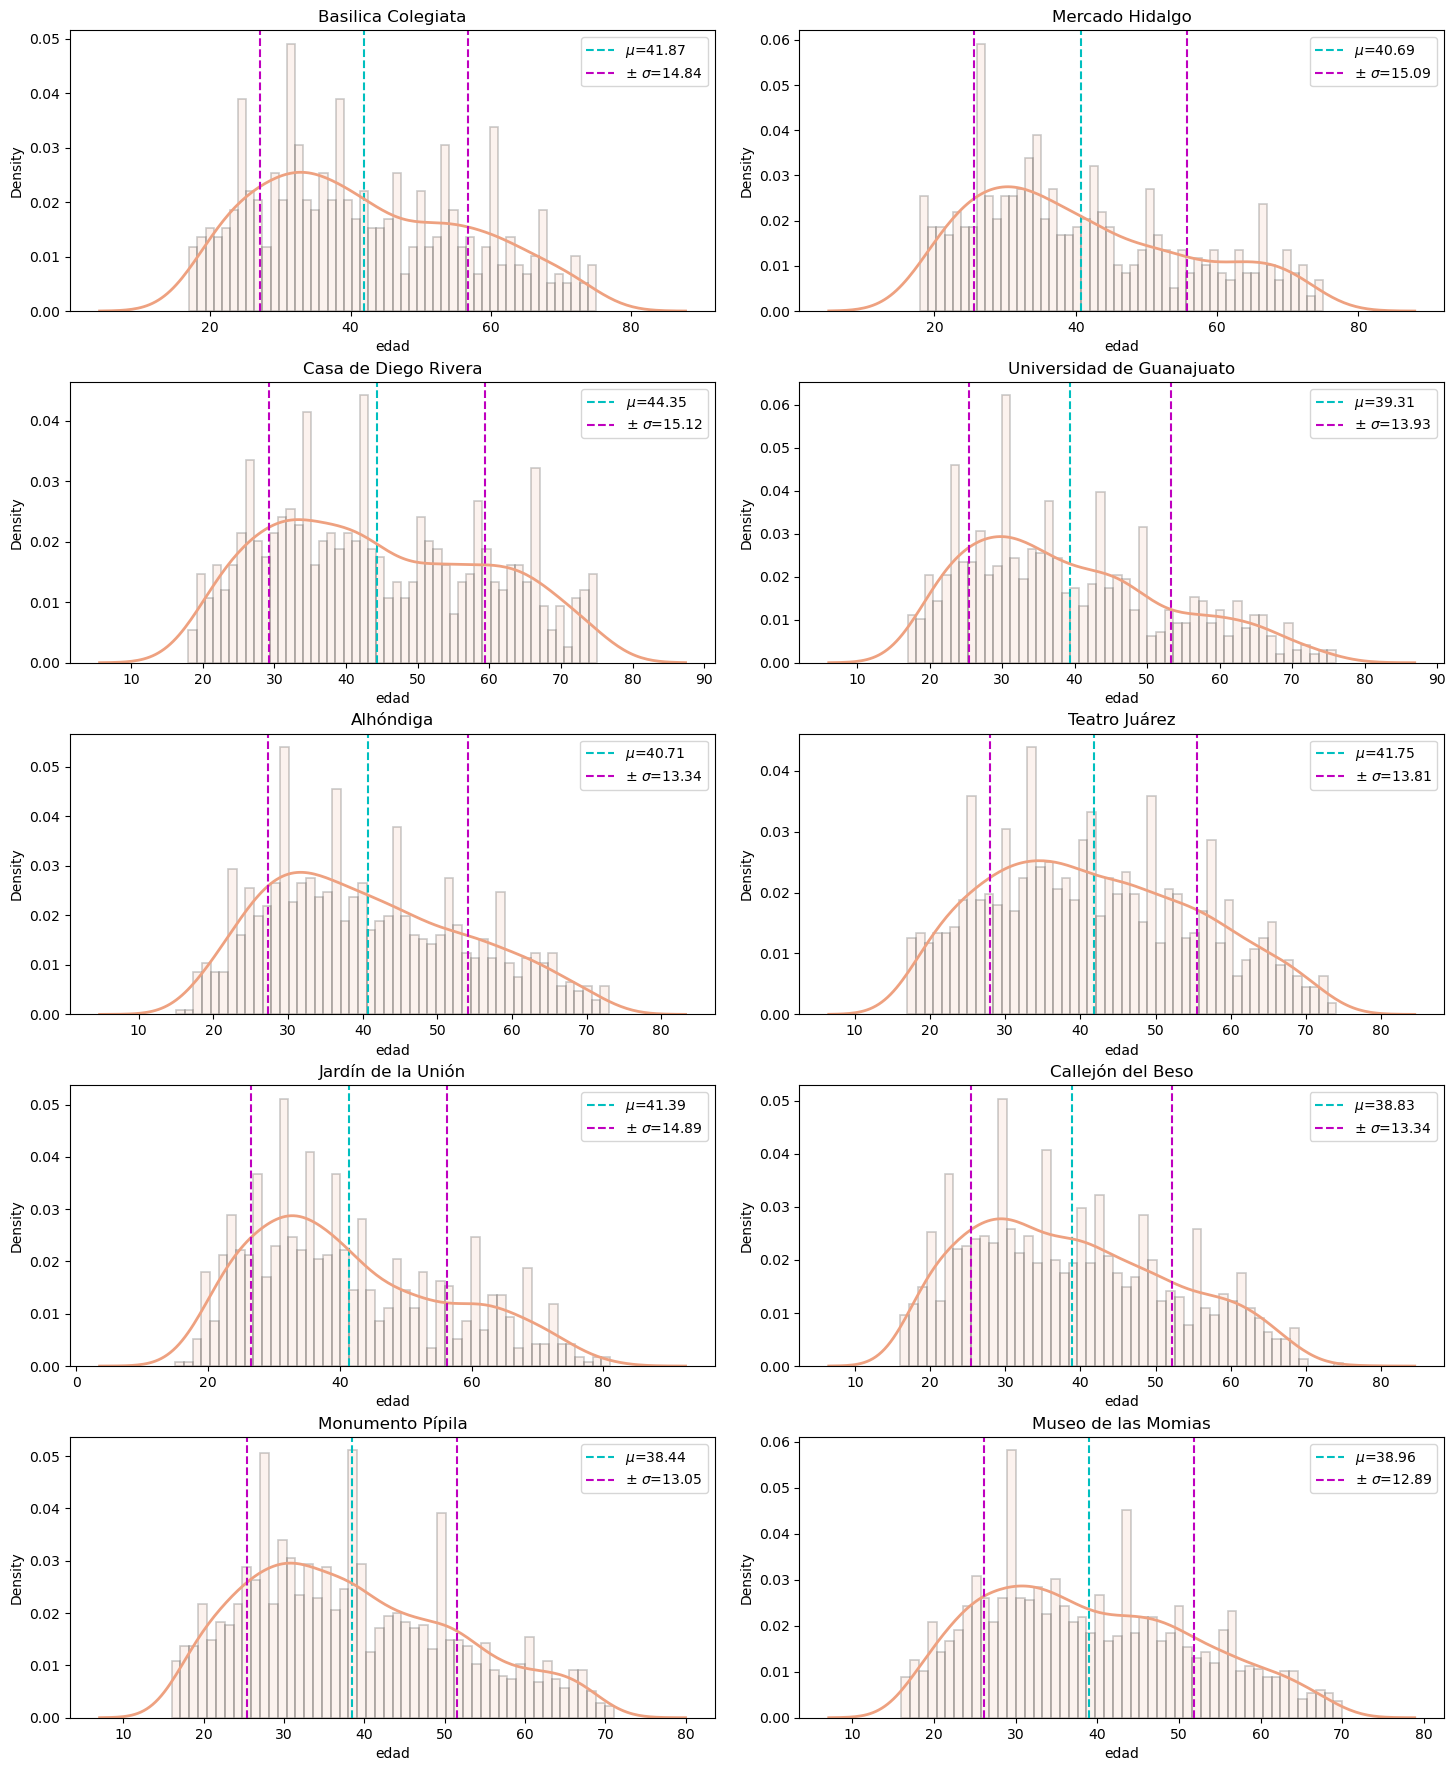

In [21]:
# Crea una nueva figura para los subgráficos
fig, axs = plt.subplots(5, 2, figsize=(15, 18))

# Ajusta el diseño de los subgráficos
fig.tight_layout(pad=3.0)
i=0
# Itera sobre los nombres de las hojas y crea un subgráfico para cada uno
for nombre_hoja,solo_nombre in zip(nombres,solo_nombres):

    # Selecciona el subgráfico actual
    ax = axs[i//2, i%2] if num_subplots > 1 else axs
    
    # Calcula el promedio y la desviación estándar de la columna 'Edad' para la hoja actual
    promedio = dataframes_por_hoja[nombre_hoja]['Edad'].mean()
    desviacion_estandar = dataframes_por_hoja[nombre_hoja]['Edad'].std()


    ax.axvline(x=promedio, color='c', linestyle='--', label=f'$\mu$={promedio:.2f}')
    #hist
    ax.hist(dataframes_por_hoja[nombre_hoja]['Edad'], bins=50,alpha=0.2, color="#f4c2ad", edgecolor='black', linewidth=1.2, density=True)
    sns.kdeplot(data=dataframes_por_hoja[nombre_hoja]['Edad'], color='#eea180', ax=ax, linewidth=2)
    #desviación estándar 
    ax.axvline(x=promedio + desviacion_estandar, color='m', linestyle='--', label=f'$\pm$ $\sigma$={desviacion_estandar:.2f}')
    ax.axvline(x=promedio - desviacion_estandar, color='m', linestyle='--')
    #título uy ejes
    ax.set_title(f'{solo_nombre}')
    ax.set_xlabel('edad')
    ax.legend()
    i=i+1
# Muestra los subgráficos
plt.show()

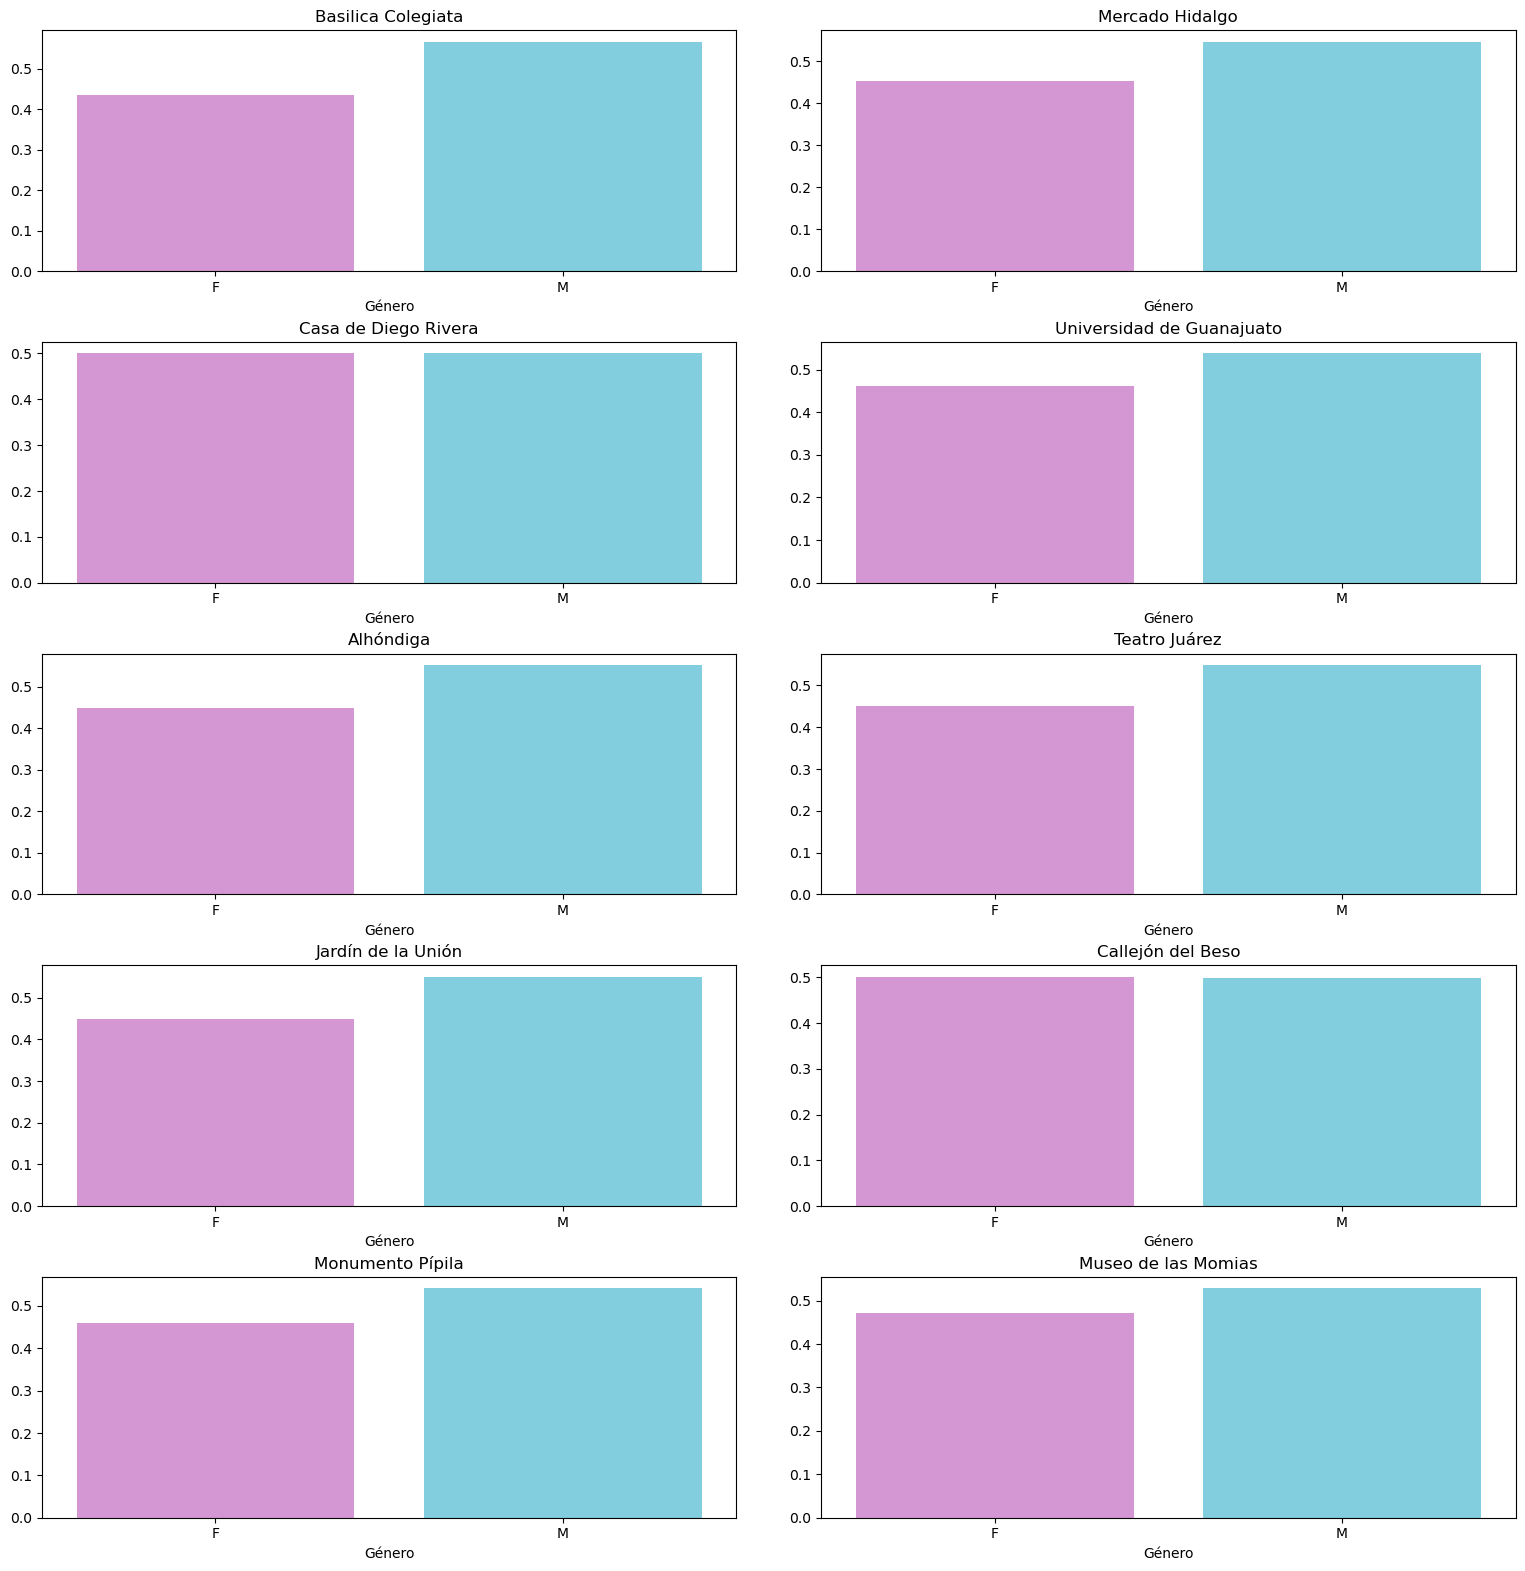

In [22]:
# Define colors to use
colors = ['#df8ddd','#74d8ed' ]
ticklabels = ['F', 'M']
# Crea una nueva figura para los subgráficos
fig, axs = plt.subplots(5, 2, figsize=(16, 16))

# Ajusta el diseño de los subgráficos
fig.tight_layout(pad=3.0)
i = 0

# Itera sobre los nombres de las hojas y crea un subgráfico para cada uno
for nombre_hoja, solo_nombre in zip(nombres, solo_nombres):

    # Selecciona el subgráfico actual
    ax = axs[i//2, i%2] if num_subplots > 1 else axs

    # Grafica el barplot de las proporciones de 'Género'
    sns.barplot(x=dataframes_por_hoja[nombre_hoja]['Género'].value_counts(normalize=True).index, 
                y=dataframes_por_hoja[nombre_hoja]['Género'].value_counts(normalize=True).values, 
                ax=ax,palette=colors)

    # Cambia las etiquetas del eje x
    ax.set_xticklabels(ticklabels)
    # Título y ejes
    ax.set_title(f'{solo_nombre}')
    ax.set_xlabel('Género')
    i += 1

# Mostrar los subgráficos
plt.show()


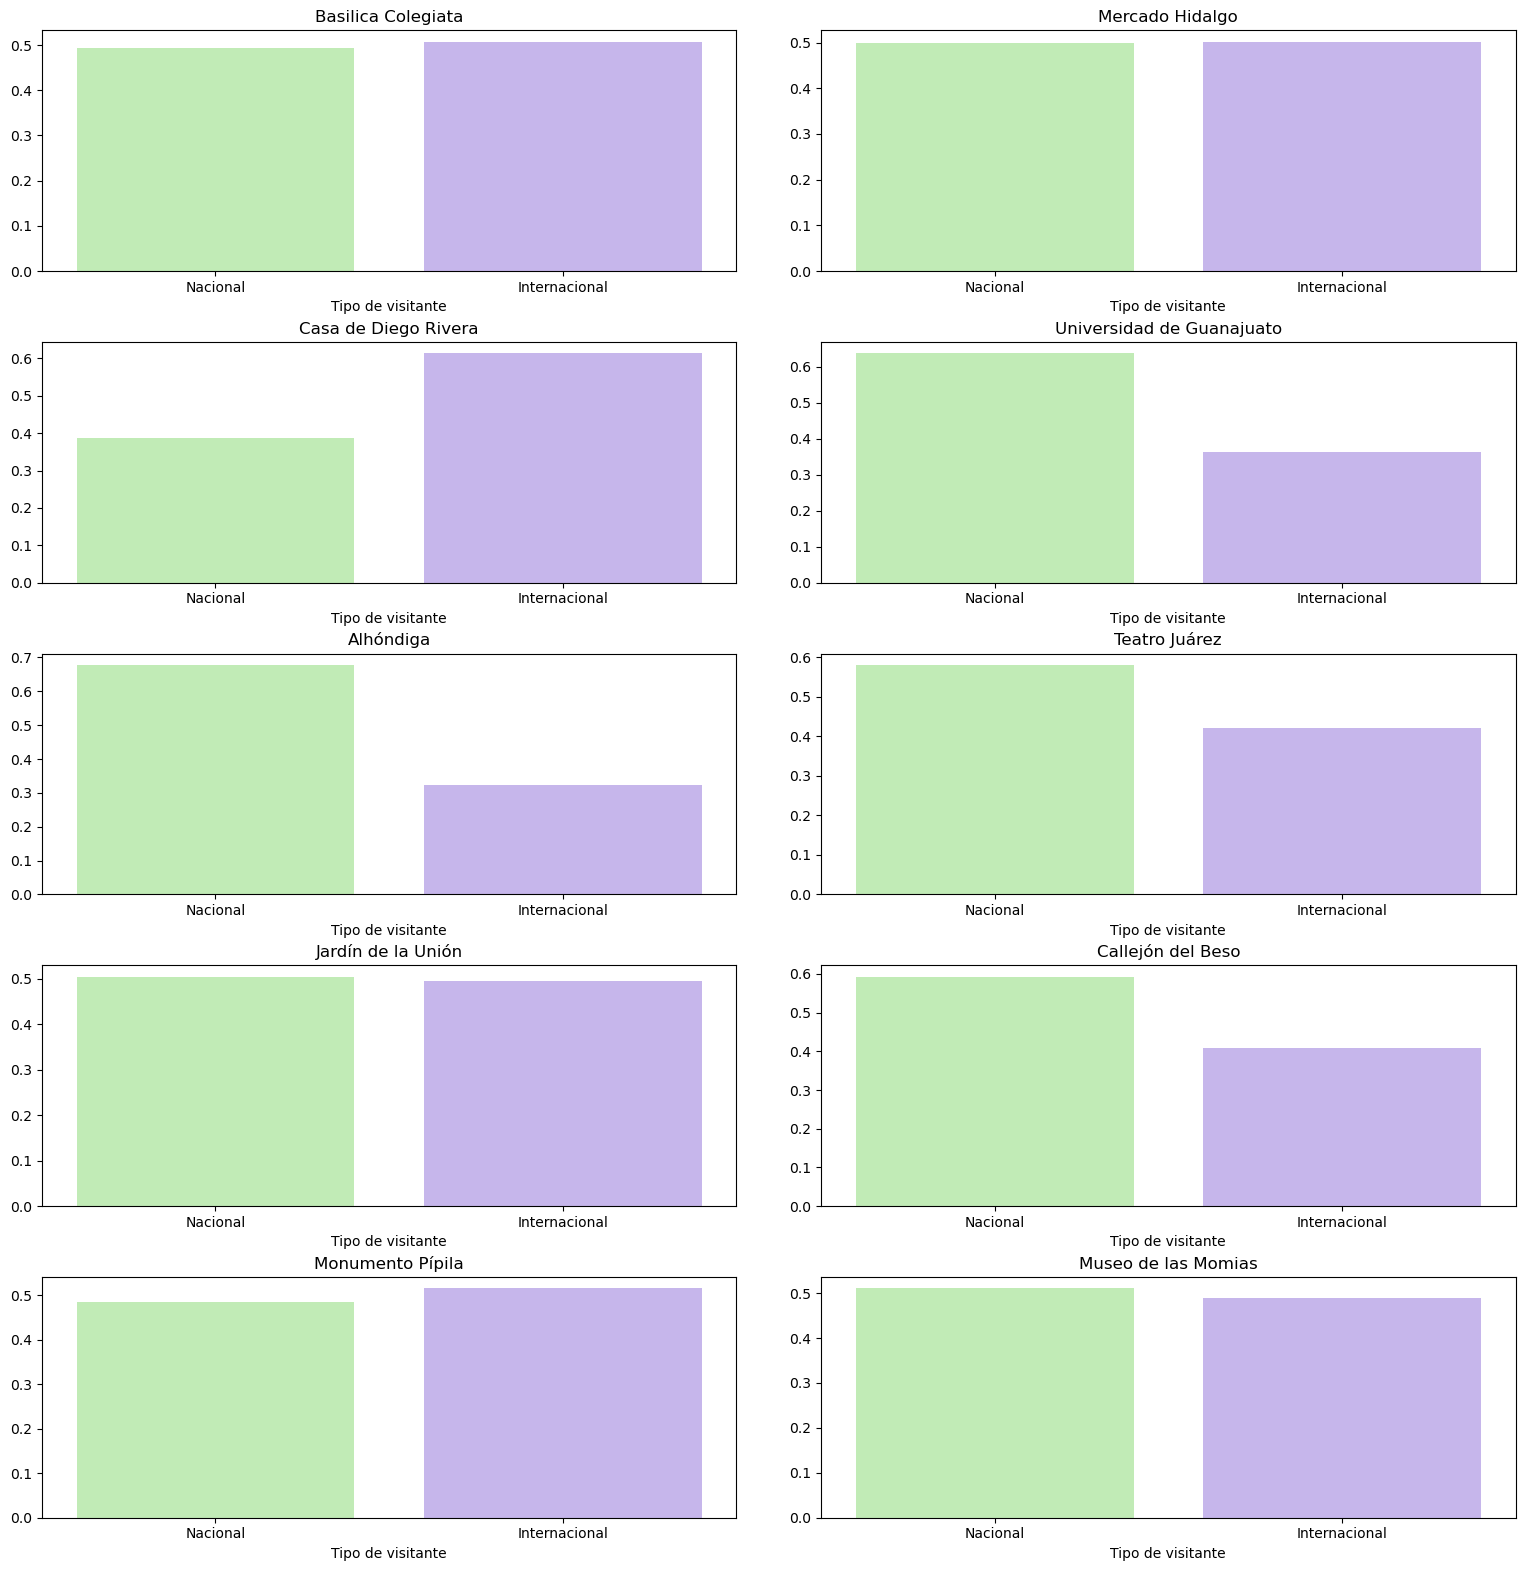

In [23]:
# Define colors to use
colors = ['#bcf4ad','#c2adf4' ]
ticklabels = ['Nacional', 'Internacional']
# Crea una nueva figura para los subgráficos
fig, axs = plt.subplots(5, 2, figsize=(16, 16))

# Ajusta el diseño de los subgráficos
fig.tight_layout(pad=3.0)
i = 0

# Itera sobre los nombres de las hojas y crea un subgráfico para cada uno
for nombre_hoja, solo_nombre in zip(nombres, solo_nombres):

    # Selecciona el subgráfico actual
    ax = axs[i//2, i%2] if num_subplots > 1 else axs

    # Grafica el barplot de las proporciones de 'Género'
    sns.barplot(x=dataframes_por_hoja[nombre_hoja]['Nacional ó Internacional'].value_counts(normalize=True).index, 
                y=dataframes_por_hoja[nombre_hoja]['Nacional ó Internacional'].value_counts(normalize=True).values, 
                ax=ax,palette=colors)

    # Cambia las etiquetas del eje x
    ax.set_xticklabels(ticklabels)

    # Título y ejes
    ax.set_title(f'{solo_nombre}')
    ax.set_xlabel('Tipo de visitante')

    i += 1

# Mostrar los subgráficos
plt.show()

<font size=2.5 color='lightblue'>

* $\textit{Ejercicio 2}$

In [24]:
def calculate_entropy(texts, labels):
    total_texts = len(texts)
    if total_texts==0: #si no hay textos en una categoria no contamos esa contribucion
        entropy=0
        return entropy
    label_counts = Counter(labels)
    entropy = 0
    for count in label_counts.values():
        probability = count / total_texts
        entropy -= probability * log2(probability)
    return entropy

def information_gain(texts, labels, word):
    #calculamos la entropía antes de la división
    total_texts = len(texts)
    label_counts = Counter(labels)
    entropy_before_split = sum(-count/total_texts * log2(count/total_texts) for count in label_counts.values())

    # Dividimos los textos en dos grupos: aquellos que contienen la palabra y aquellos que no
    texts_with_word = [text for text, label in zip(texts, labels) if word in text]
    texts_without_word = [text for text, label in zip(texts, labels) if word not in text]

    #calculamos la entropía después de la división
    entropy_with_word = calculate_entropy(texts_with_word, labels)
    entropy_without_word = calculate_entropy(texts_without_word, labels)

    #calculamos el Information Gain
    total_texts_with_word = len(texts_with_word)
    total_texts_without_word = len(texts_without_word)
    total_texts = total_texts_with_word + total_texts_without_word
    information_gain = entropy_before_split - ((total_texts_with_word / total_texts) * entropy_with_word + (total_texts_without_word / total_texts) * entropy_without_word)

    return information_gain

def information_gain_for_words(texts, labels, words):
    gains = []
    for word in words:
        gain = information_gain(texts, labels, word)
        gains.append((word, gain))
    return sorted(gains, key=lambda x: x[1], reverse=True)

def nube_palabras(coleccion,dict_indices,labels,k):

    words_colection =[key for key,value in dict_indices.items() ]
    gains = information_gain_for_words(coleccion, labels, words_colection)
    gainsk = gains[:k]
    #diccionario donde las palabras son las llaves y la ganancia de información es el valor
    word_gain_dict = {word: gain for word, gain in gainsk}

    #nube de palabras con el tamaño basado en la ganancia de información
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(word_gain_dict)

    #graficamos nube de palabras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    

Nube de palabras para Basilica Colegiata


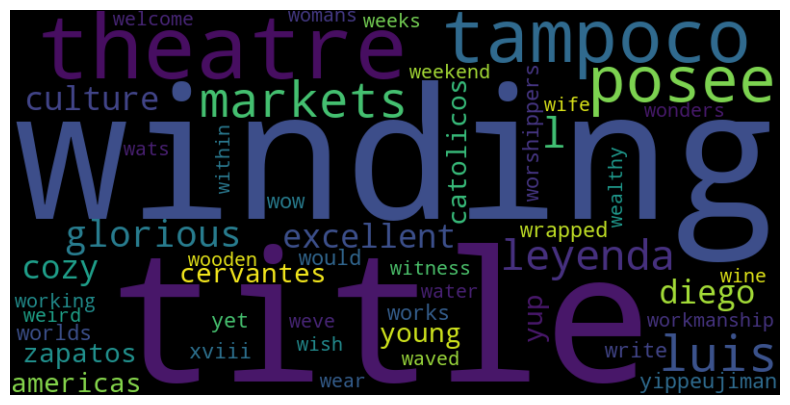

Nube de palabras para Mercado Hidalgo


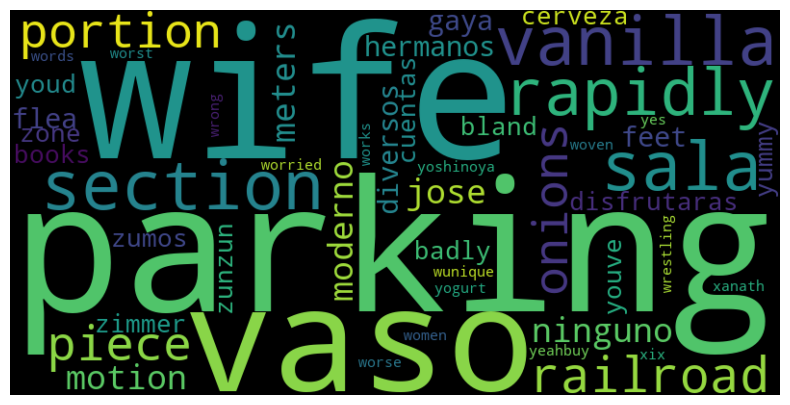

Nube de palabras para Casa de Diego Rivera


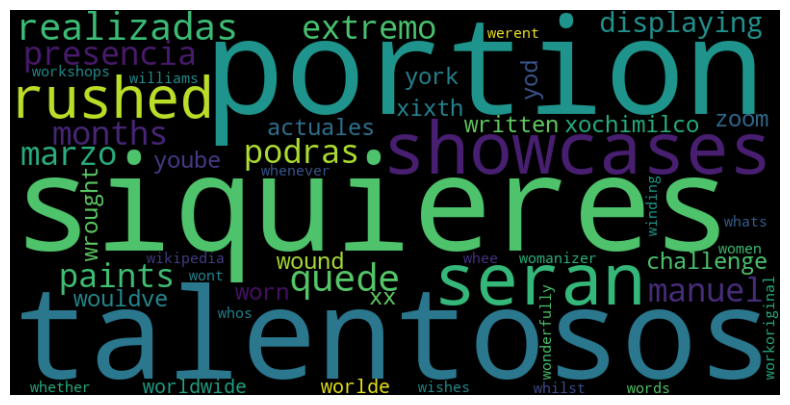

Nube de palabras para Universidad de Guanajuato


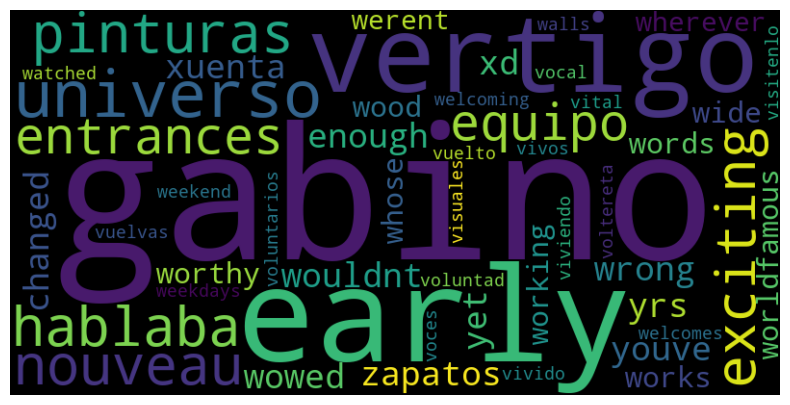

Nube de palabras para Alhóndiga


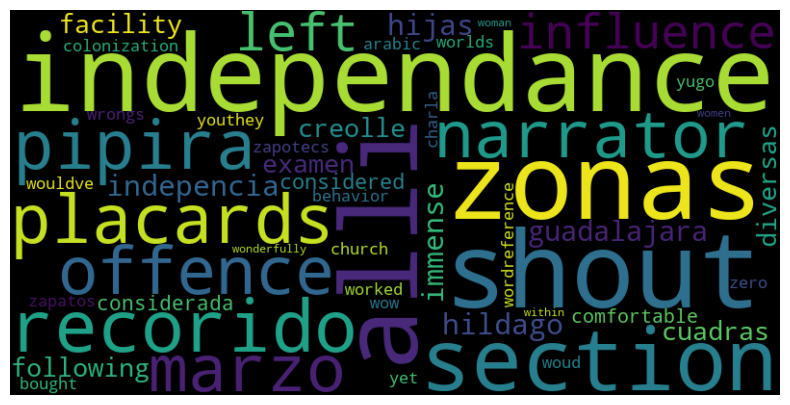

Nube de palabras para Teatro Juárez


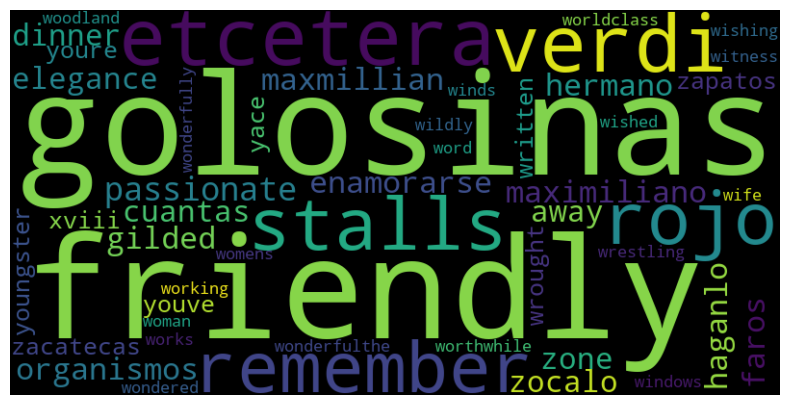

Nube de palabras para Jardín de la Unión


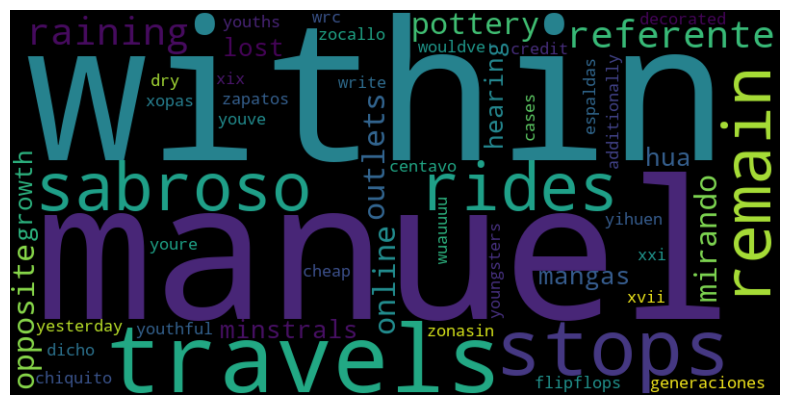

Nube de palabras para Callejón del Beso


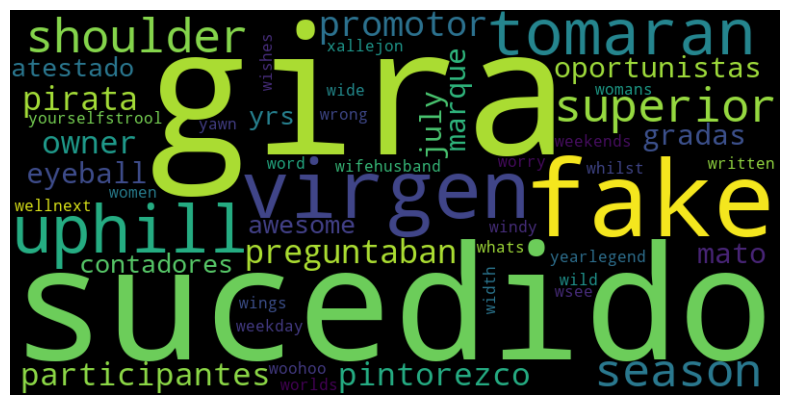

Nube de palabras para Monumento Pípila


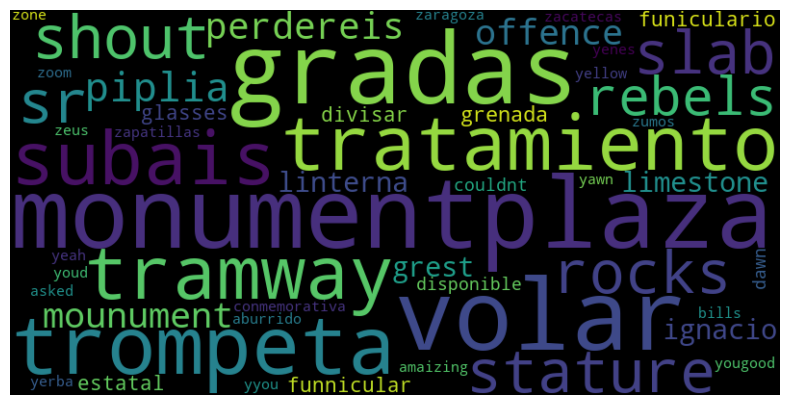

Nube de palabras para Museo de las Momias


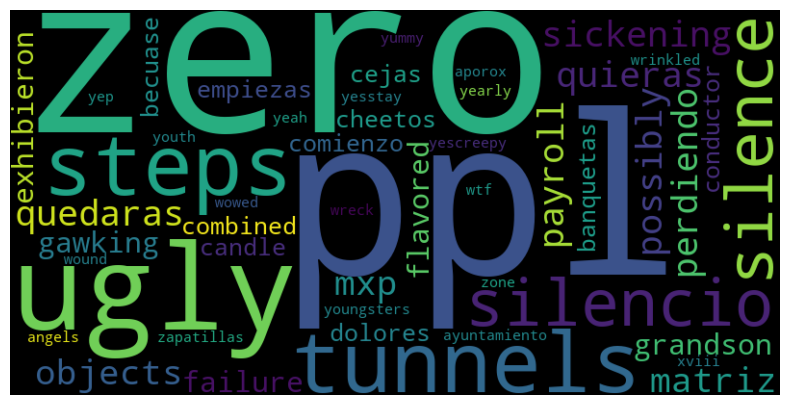

In [25]:
for i,solo_nombre in enumerate(solo_nombres): 
    print("Nube de palabras para", solo_nombre)
    nube_palabras(listas_opiniones_limpia[i],lista_dict_indices[i],listas_escala[i],50)

<font size=2.5 color='lightblue'>

* $\textit{Ejercicio 4}$

Usaremos como opiniones negativas aquellas que tengan una escala de 1 o 2

In [26]:
listas_opiniones_negativas=[]
listas_escalas_negativas=[] 

for i,nombre_hoja in enumerate(nombres):
        
    if i!=5: #para el teatro juarez tomamos en cuenta tambien las opiniones neutras pues sólo hay una negativa   
        opiniones_negativas=[listas_opiniones_limpia[i][j] for j,escala in enumerate(listas_escala[i]) if listas_escala[i][j]==1 or listas_escala[i][j]==2]
        escalas_negativas=[listas_escala[i][j] for j,escala in enumerate(listas_escala[i]) if listas_escala[i][j]==1 or listas_escala[i][j]==2]
    else:
        opiniones_negativas=[listas_opiniones_limpia[i][j] for j,escala in enumerate(listas_escala[i]) if listas_escala[i][j]==1 or listas_escala[i][j]==2 or listas_escala[i][j]==3]
        escalas_negativas=[listas_escala[i][j] for j,escala in enumerate(listas_escala[i]) if listas_escala[i][j]==1 or listas_escala[i][j]==2 or listas_escala[i][j]==3]

    listas_opiniones_negativas.append(opiniones_negativas)
    listas_escalas_negativas.append(escalas_negativas)

Ejemplo de opiniones negativas para el muso de las momias:

In [27]:
listas_opiniones_negativas[9][:10]

['is not a place to celebrate death… they just show old dead bodies like a circus… not sure this is good for showing our culture…',
 'i did not choose to visit this place it was part of a city tour that we innocently booked these are not actually mummies  they are the disinterred corpses of a past cholera epidemic the dead bodies of men women and children who instead of being provided with a dignified burial were as their families lacked the funds instead dumped in a storage facility where unscrupulous employees began to display them to visitors interested in a grisly sight for money and no this is not the anthropologically interesting reflection of mexicos different attitude to death i live in santa fe and am well familiar with the day of the dead with candies in the shape of skulls etc etc this is an irreverent horrible and inexcusable disrespect of the dead bodies of people who obviously based on their hideous grimaces died in great agony and did not choose to be gaped at by idiots 

In [28]:
listas_escalas_negativas[9][:10]

[1, 1, 2, 1, 2, 1, 2, 2, 2, 1]

Ahora creamos el corpus, y los diccionarios pero usando sólo la las opiniones negativas

In [29]:
lista_corpus_neg=[]
lista_dict_freq_neg=[]
lista_dict_indices_neg=[]

for i,nombre_hoja in enumerate(nombres):
    #Generamos el corpus
    corpus_palabras=create_corpus_from_text(listas_opiniones_negativas[i])
    #quitamos stopwords
    corpus_filtrado = [word for word in corpus_palabras if word not in stop_words]
    #Generamos diccionario de frecuencias con las primeras 5 mil palabras sin stop words
    dict_freq=create_dic_freq(corpus_filtrado,5000)
    #Generamos diccionario de indices
    dict_indices=create_dic_ranking(dict_freq)
    
    #guardamos en una lista de listas cada corpus, diccionario de frecuencias y de rankings
    lista_corpus_neg.append(corpus_filtrado)
    lista_dict_freq_neg.append(dict_freq)
    lista_dict_indices_neg.append(dict_indices)  

Es interesante ver el numero total de opiiones negativas de cada lugar 

In [30]:
print("Opiniones negativas por lugar")
for i,nombre_hoja in enumerate(nombres):
    print("*",nombre_hoja,"\n",len(listas_opiniones_negativas[i]))

Opiniones negativas por lugar
* Basilica Colegiata 560 
 3
* Mercado Hidalgo 600 
 35
* Casa de Diego Rivera 698 
 16
* Universidad de Guanajuato 900 
 4
* Alhóndiga 930 
 18
* Teatro Juárez 1,010 
 28
* Jardín de la Unión 1,134 
 5
* Callejón del Beso 1,360 
 78
* Monumento Pípila 1,620 
 29
* Museo de las Momias 1,650 
 237


Nube de palabras para Basilica Colegiata


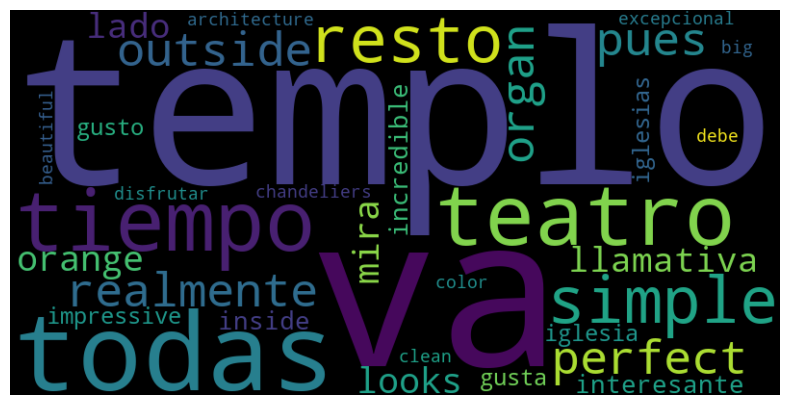

Nube de palabras para Mercado Hidalgo


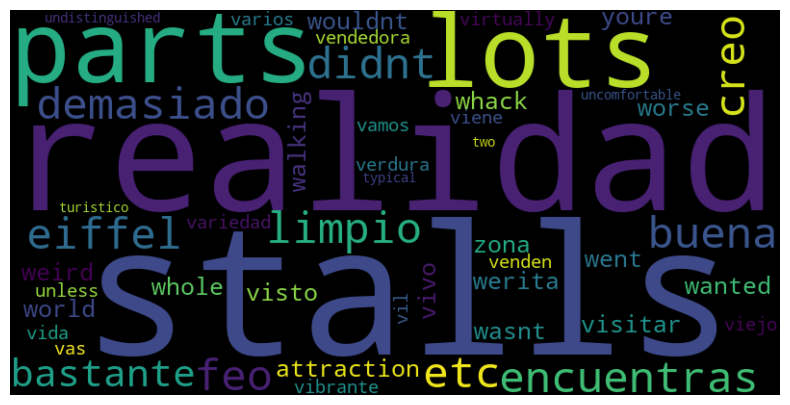

Nube de palabras para Casa de Diego Rivera


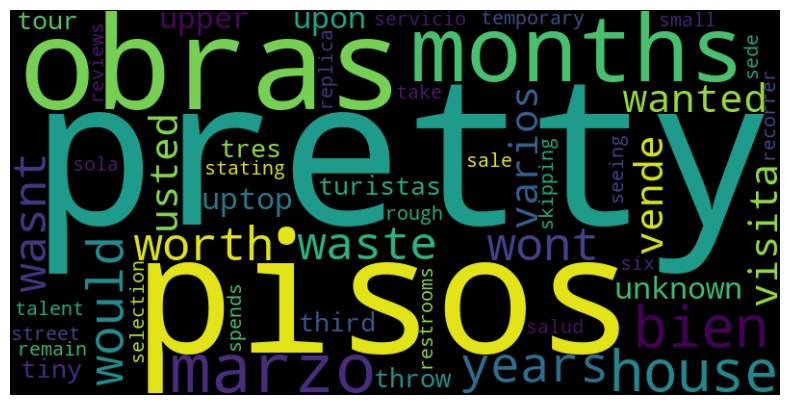

Nube de palabras para Universidad de Guanajuato


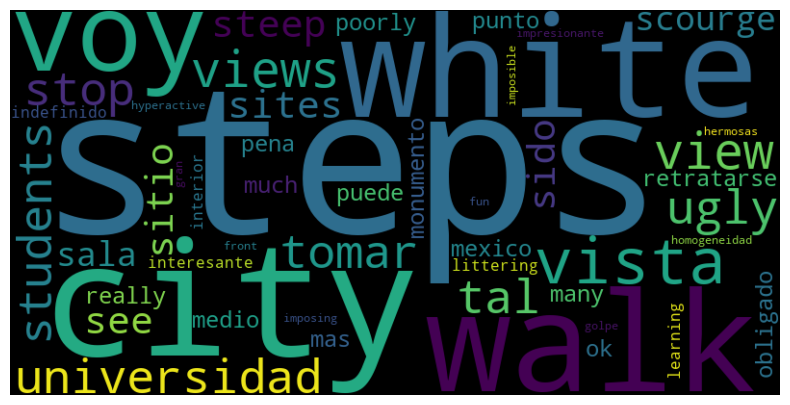

Nube de palabras para Alhóndiga


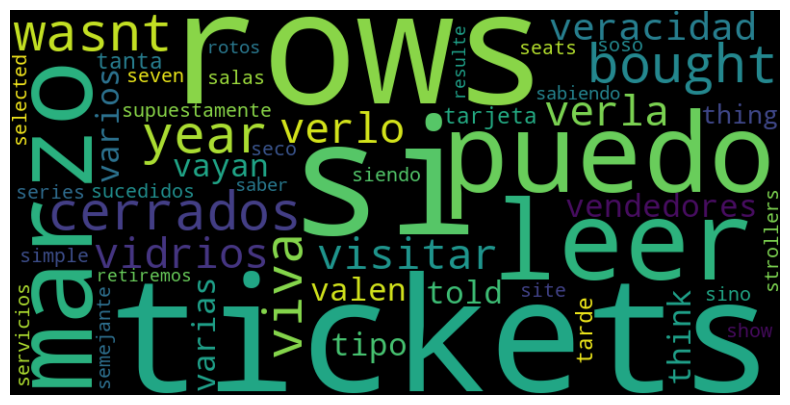

Nube de palabras para Teatro Juárez


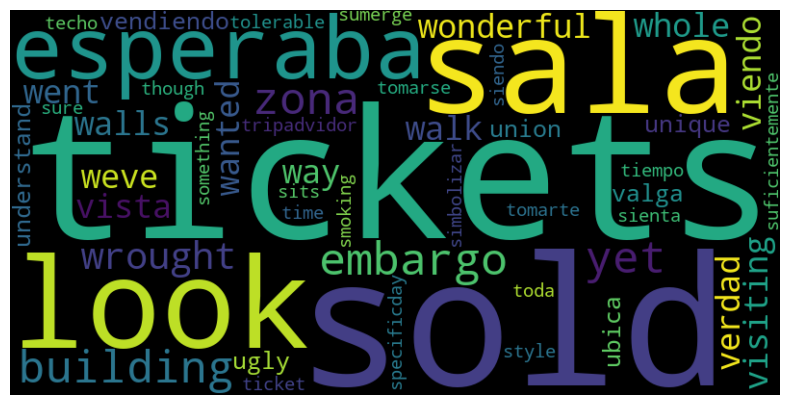

Nube de palabras para Jardín de la Unión


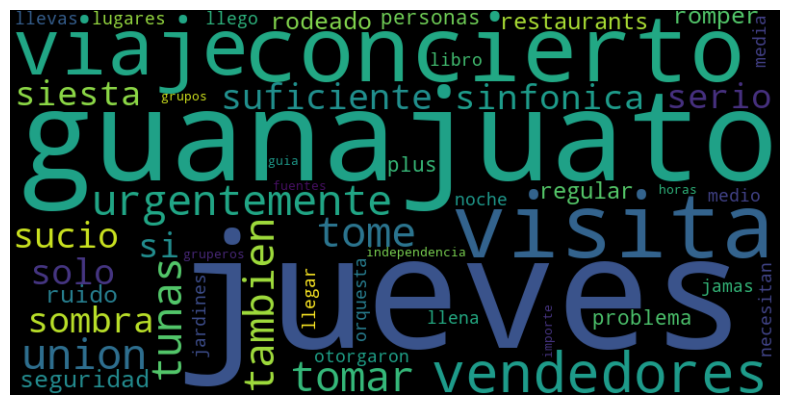

Nube de palabras para Callejón del Beso


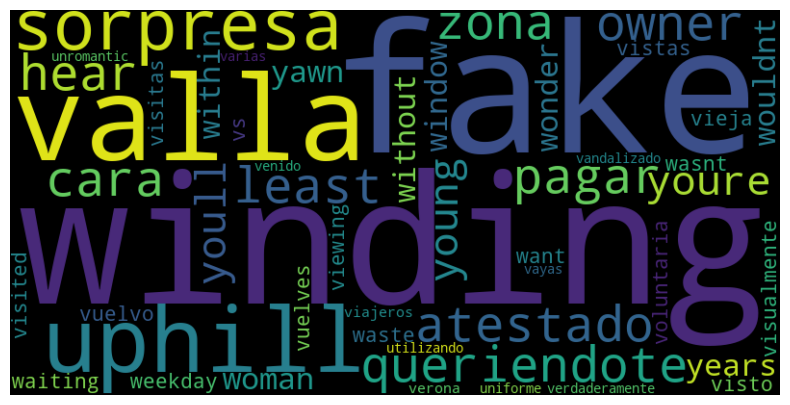

Nube de palabras para Monumento Pípila


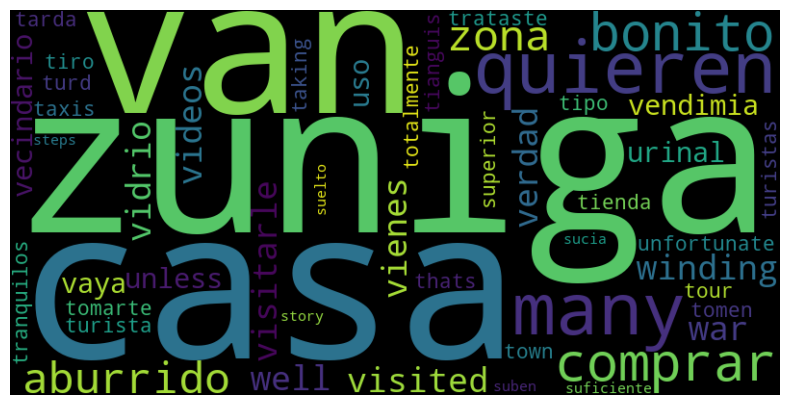

Nube de palabras para Museo de las Momias


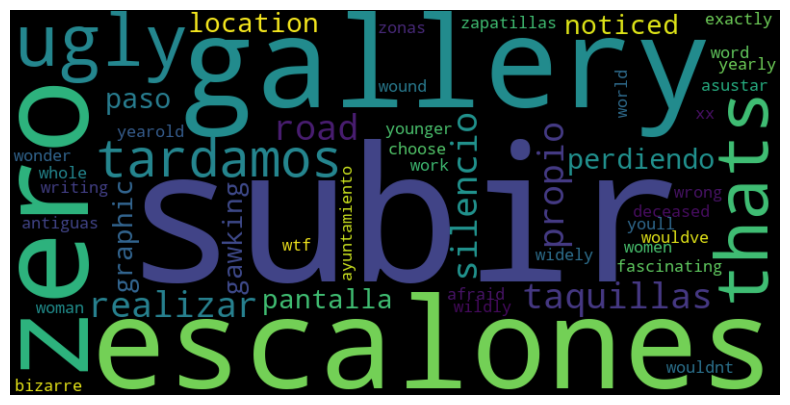

In [31]:
for i,solo_nombre in enumerate(solo_nombres): 
    print("Nube de palabras para", solo_nombre)
    nube_palabras(listas_opiniones_negativas[i],lista_dict_indices_neg[i],listas_escalas_negativas[i],50)

<font size=2.5 color='lightblue'>

* $\textit{Ejercicio 5}$

In [32]:
exp_reg = r'\b[A-Za-z]+\b'  # \b indica límites de palabra, [A-Za-z]+ coincide con una o más letras 
tokenizer = RegexpTokenizer(exp_reg)



#________________________________PESADO_FRECUENCIA________________________________#

#matriz_nxm de bolsa de palabras n=numero de textos, m=numero de palabras (5000)
def build_freq_bow(tr_txt,dic_feq,dic_inices):
    BoW=np.zeros((len(tr_txt),len(dic_feq)),dtype=int) #construimos bolsta de palabras en ceros
    cont_documento=0 #indice que recorre las FILAS
 
    for tr in tr_txt:#recorremos cada documento
        fdist_doc=nltk.FreqDist(tokenizer.tokenize(tr))#hacemos freqDist (tokenizado con el tokenizador ya definido) de cada documento
        for word in fdist_doc: #para cada palabra en el diccionario del documento
            if word in dic_inices: #si la palabra está en el corte final
                #le asignamos su frecuencia
                BoW[cont_documento,dic_inices[word]] = fdist_doc[word]

        cont_documento+=1

    return BoW

#________________________________PESADO_TFIDF________________________________#

#primero calculamos el num de documentos en que aparece cada palabra
def df(tr_txt, dic_indices):
    df = np.zeros(5000, dtype=int)

    # comp list para las frecuencias de cada documento
    fdist_docs = [nltk.FreqDist(tokenizer.tokenize(tr)) for tr in tr_txt]

    #iteramos sobre cada palbra
    for word in dic_indices:
        #obtenemos el indice de la palabra
        index = dic_indices[word] 
        for j,fdist_doc in enumerate(fdist_docs): #iteramos osbre cada documento
            if word in fdist_doc: #si la palabra está en el documento actual
                df[index] += 1 #agredamos uno al conador de esa palabra

    return df

#
def build_tfidf_bow(tr_txt, dic_freq, dic_indices):
    BoW = build_freq_bow(tr_txt, dic_freq, dic_indices) #la bolsa de palabras de frecuencias es el tf
    df_list = df(tr_txt, dic_indices) #llamamos a la duncion df
    N = len(tr_txt)
   
    for i in range(N):
        for j,df_val in enumerate(df_list): 
            if df_val!=0: #si df es distinto de ceo (puede ser cero para el conjunto de validacion, por ejemplo que contiene menos lementos )
                BoW[i][j] *= np.log(N / df_val) #tfxdf

    return BoW

In [35]:
prueba=build_tfidf_bow(listas_opiniones_limpia[0],lista_dict_freq[0],lista_dict_indices[0])

In [36]:
prueba.shape

(560, 3276)

<font size=2.5 color='lightblue'>

* $\textit{Ejercicio 6}$